In [1]:
require 'cunn'

----------------------------------------------------------------------

tar = 'http://torch7.s3-website-us-east-1.amazonaws.com/data/mnist.t7.tgz'

if not paths.dirp('mnist.t7') then
   os.execute('wget ' .. tar)
   os.execute('tar xvf ' .. paths.basename(tar))
end

trainFile = 'mnist.t7/train_32x32.t7'
testFile = 'mnist.t7/test_32x32.t7'

----------------------------------------------------------------------

print '==> loading dataset'

trainSet = nil
testSet = nil
train = torch.load(trainFile,'ascii')
test = torch.load(testFile,'ascii')
------------------------------------

==> loading dataset	


In [2]:
-- select train and test set
trainSet = {data = train.data[{ {1,6000}, {}, {} }],
            label = train.labels[ { {1, 6000} } ]}
testSet = {data = test.data[{ {1,1000}, {}, {} }],
           label = test.labels[ { {1, 1000} } ]}

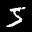

In [3]:
-- sample image
require 'image'
itorch.image(trainSet.data[1])
print(trainSet.label[1]) -- label from '1' to '10', '1' is 0, '10' is 9

In [4]:
-- normalize data
trainSet.data = trainSet.data:cuda():div(255)
mean = trainSet.data:mean()
trainSet.data = trainSet.data:add(-mean)
trainSet.label = trainSet.label:cuda()

testSet.data = testSet.data:cuda():div(255)
testSet.data = testSet.data:add(-mean)
testSet.label = testSet.label:cuda()

trsize = trainSet.data:size(1)
tesize = testSet.data:size(1)

In [5]:
-- cnn structure
require 'nn'

cnn = nn.Sequential()
cnn:add(nn.SpatialConvolution(1, 6, 5, 5)) -- 1 input image channel, 6 output channels, 5x5 convolution kernel
cnn:add(nn.ReLU())                       -- non-linearity 
cnn:add(nn.SpatialMaxPooling(2,2,2,2))     -- A max-pooling operation that looks at 2x2 windows and finds the max.
cnn:add(nn.SpatialConvolution(6, 16, 5, 5))
cnn:add(nn.ReLU())                       -- non-linearity 
cnn:add(nn.SpatialMaxPooling(2,2,2,2))
cnn:add(nn.View(16*5*5))                    -- reshapes from a 3D tensor of 16x5x5 into 1D tensor of 16*5*5
cnn:add(nn.Linear(16*5*5, 120))             -- fully connected layer (matrix multiplication between input and weights)
cnn:add(nn.ReLU())                       -- non-linearity 
cnn:add(nn.Linear(120, 84))
cnn:add(nn.ReLU())                       -- non-linearity 
cnn:add(nn.Linear(84, 10))                   -- 10 is the number of outputs of the network (in this case, 10 digits)
cnn:add(nn.LogSoftMax())                     -- converts the output to a log-probability. Useful for classification problems
cnn = cnn:cuda()

In [6]:
-- cnn criterion
criterion = nn.ClassNLLCriterion() -- a negative log-likelihood criterion for multi-class
criterion = criterion:cuda()

In [7]:
-- batch gd

batchSize = 500
batchInd = torch.zeros(batchSize)

maxEpoch = 2000

tra_loss = torch.zeros(maxEpoch)
tes_loss = torch.zeros(maxEpoch)
eta = 0.2
n = 1

for k = 1, maxEpoch do
    
    -- generate batch index
    for i = 1, batchSize do
        batchInd[i] = torch.random(1, 6000)
    end
    
    -- define batch set
    Batch = { data  = trainSet.data:index(1, batchInd:long()),
              label = trainSet.label:index(1, batchInd:long())}
    
    -- train by batch
    cnn:zeroGradParameters() -- zero gradient parameters
    local outputs = cnn:forward(Batch.data) -- forward
    local loss = criterion:forward(outputs, Batch.label) -- calculate loss
    local dloss_doutputs = criterion:backward(outputs, Batch.label)
    cnn:backward(Batch.data, dloss_doutputs)
    tra_loss[n] = loss -- store train loss
    cnn:updateParameters(eta) 

    -- test current network
    pred = cnn:forward(testSet.data) 
    test_loss = criterion:forward(pred, testSet.label)
    tes_loss[n] = test_loss -- store test loss

    n = n + 1 
end

In [8]:
require 'gnuplot'

gnuplot.pngfigure('p4loss1.png')
gnuplot.plot({'train loss', tra_loss, '-'},
             {'test loss', tes_loss, '-'})
gnuplot.plotflush()
gnuplot.grid(true)
gnuplot.title('train.loss.cnn')

![p4loss1.png](p4loss1.png)

In [9]:
-- display performance by right classification
correct = 0
for i=1,1000 do
    local groundtruth = testSet.label[i]
    local prediction = cnn:forward(testSet.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    if groundtruth == indices[1] then
        correct = correct + 1
    end
end

print(correct, 100*correct/1000 .. ' % ')

962	96.2 % 	


In [10]:
--[[
part 2: xor network
since we want to determine if two input image have same digits
first we forward 2 images to cnn, then get result of two log probability distribution on all classes
If two input image have same digits, the distribution are similar, 
we could use KL divergence to calculate the distance between two outputs from cnn,
then train a threshold neuron to classify if two distribution are same
--]]

-- net1: two parallel cnn
-- inputs: two image
-- outputs: two log probability distribution
net1 = nn.Sequential():cuda()
cnn1 = cnn:clone()
cnn2 = cnn:clone()
cnn_layer = nn.ParallelTable()
cnn_layer:add(cnn1)
cnn_layer:add(cnn2)
net1:add(cnn_layer)

-- xor: inputs are KLdist of two probability distribution
-- output: probability of two distribution are same
xor = nn.Sequential():cuda()
xor:add(nn.Linear(1, 1))
xor:add(nn.Sigmoid())

-- xor network criterion
xor_criterion = nn.MSECriterion()

In [11]:
-- split whole data set by their class number
-- return a 10 class table
function SetClass(Set)
    local Class = {}
    for i = 1, 10 do
        local ind = Set.label:eq(i):nonzero():long():view(-1)
        local c = {data  = Set.data:index(1, ind),
                   label = Set.label:index(1, ind)}
        table.insert(Class, c)
    end
    
    return Class
end    

-- split both train and test
traClass = SetClass(trainSet)
tesClass = SetClass(testSet)

In [12]:
-- generate batch Data to train xor net
-- to train xor we need the data set of two images are balance
-- e.g.: 
--    now we need a data set with a bunch of two images, 
--    and their label is 1 if they have same digits, otherwise the label is 0
--    to train a network, we need data of label 1 and data of label 0 are roughly equal
--

function BatchData(k, Class)
    
    local cInd = torch.random(1, 10) -- randomly select a class number from 1 to 10
    local dInd1 = torch.random(1, Class[cInd].label:size(1)) -- randomly select an instance from that class
    local d1 = Class[cInd].data[dInd1] -- get that data
    local l1 = Class[cInd].label[dInd1] -- get that class number
    
    -- if k is even
    -- we randomly select a class number from 1 to 10
    -- else we keep using previous class number
    if k % 2 == 0 then 
        cInd = torch.random(1, 10)
    end
    
    
    local dInd2 = torch.random(1, Class[cInd].label:size(1)) -- randomly select an instance from that class
    local d2 = Class[cInd].data[dInd2] -- get that data
    local l2 = Class[cInd].label[dInd2] -- get that label

    
    -- if two class number are same, label is 1, otherwise 0
    if l1 == l2 then
        xor_l = torch.Tensor{1}
    else
        xor_l = torch.Tensor{0}
    end

    local xor_d = {d1, d2}
    batchd = {data = xor_d, label = xor_l}
    return batchd
end

In [13]:
-- calculate KL distance from two loglikelihood distribution
-- if two distribution are similar, the output is near 0, otherwise the distance is large
KL = nn.DistKLDivCriterion():cuda()
function KLDist(X)
    local x = torch.round(X[1])
    local target = torch.round(X[2])

    local target = nn.Exp():cuda():forward(target)
    local output = torch.Tensor(1)
    output[1] = KL:forward(x, target)
    return output
end

In [14]:
-- train xor
maxEpoch = 500
xor_tra_loss = torch.zeros(maxEpoch)
xor_tes_loss = torch.zeros(maxEpoch)

tra_bsize = 10
tes_bsize = 10

eta = 0.01
n = 1

for k = 1, maxEpoch do 
    
    xor:zeroGradParameters()
    tra_bloss = 0
    for i = 1, tra_bsize do
        local btra_Data = BatchData(k, traClass) -- select data from train set
        local inputs = net1:forward(btra_Data.data)
        local KLD = KLDist(inputs)
        local outputs = xor:forward(KLD) -- train xor classifier
        local loss = xor_criterion:forward(outputs, btra_Data.label)
        local dloss_doutputs = xor_criterion:backward(outputs, btra_Data.label)
        xor:backward(KLD, dloss_doutputs)
        tra_bloss = tra_bloss + loss -- update batch train loss
    end
    xor_tra_loss[n] = tra_bloss/tra_bsize
    xor:updateParameters(eta)
    
    tes_bloss = 0
    for i = 1, tes_bsize do
        local btes_Data = BatchData(k, tesClass) -- select data from test set
        local inputs = net1:forward(btes_Data.data)
        local inputs = KLDist(inputs)
        local outputs = xor:forward(inputs) -- test xor classifier
        local loss = xor_criterion:forward(outputs, btes_Data.label)
        tes_bloss = tes_bloss + loss -- update batch test loss
    end
    xor_tes_loss[n] = tes_bloss/tes_bsize 
    
    n = n + 1
    -- print(n)
end    

In [15]:
require 'gnuplot'

gnuplot.pngfigure('p4loss2.png')
gnuplot.plot({'train loss', xor_tra_loss, '-'},
             {'test loss', xor_tes_loss, '-'})
gnuplot.plotflush()
gnuplot.grid(true)
gnuplot.title('train.loss.cnn.xor')

![p4loss2](p4loss2.png)

In [16]:
N = 10000
require 'image'
correctness = 0

for i = 1, N do
    local btes_Data = BatchData(i, tesClass)
    -- itorch.image(btes_Data.data)
    local inputs = net1:forward(btes_Data.data)
    local inputs = KLDist(inputs)
    local outputs = xor:forward(inputs)
    if outputs[1] > 0.5 then
        pred = 1
    else
        pred = 0
    end
    
    -- print({btes_Data.label[1], pred})
    
    if btes_Data.label[1] == pred then
        correctness = correctness + 1
    end    
    
end

print(correctness / N)

0.9609	
